# 0. TO DO

* EDA (DATA PREPROCESSING: Check Ouliers,)
* FEATURE ENGINEERING
* MODEL SELECTION & TRAINING



<br />

---
# **1. LIBRARIES & DATA IMPORT**
---

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import mahalanobis


1.1. IMPORT DATASET FROM CSV

In [8]:
# file path
csv_path = "../dataset/TAIPEI_diabetes.csv" 

# create dataframe to start exploring
diabete_df = pd.read_csv(csv_path)

# check if the dataset is correctly created
# diabete_df

1.2. Functions to be modularized

In [9]:
# A function that allows to check if the data points data types corresponds to their columns' data type
def dtype_per_column(df):
    # pour modifier l'affichage en tableau
    new_df = pd.DataFrame()
    new_df["column"] = df.columns
    type_count = []
    for col in df.columns:
        dtype_count = {}

        for i in df[col]:
            dtype_name = type(i).__name__
            if dtype_name in dtype_count:
                dtype_count[dtype_name] = dtype_count[dtype_name] + 1
            else:
                dtype_count[dtype_name] = 1
       
        for dtype_name in dtype_count:
            # Pour modifier l'affichage
            type_count.append(f"{dtype_name}:{dtype_count[dtype_name]}")
    new_df["type_count"] = type_count
    return new_df.T

# A function that allows to generate and compare descriptive statistics for a specific column across multiple dataframes
def compare_statistics_per_col(dataframes, dataframes_names, column):
    descriptive_statistics = []
    
    for df in dataframes:
        statistics = df[column].describe()
        descriptive_statistics.append(statistics)
    
    result = pd.concat(descriptive_statistics, axis=1, keys=dataframes_names)

    print("---" * 10)
    print(f"Comparison of descriptive statistics for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    return result

# A function that allows to generate and compare histograms for a specific column across multiple dataframes
def compare_histograms_per_col(dataframes, dataframes_names, column):

    n = len(dataframes)
    fig, axes = plt.subplots(ncols=n, nrows=1, figsize=(5 * n, 4))
    
    for i in range(n):
        ax = axes[i]
        df = dataframes[i]
        name = dataframes_names[i]
        sns.histplot(data=df, x=column, ax=ax, kde=True)
        ax.set_title(f"{name}")
    
    print("---" * 10)
    print(f"Comparison of data distributions for \x1B[4m{column}\x1B[0m:")
    print("---" * 10)
    
    plt.tight_layout()
    plt.show()


# A function that generates point cloud from two difference columns of the dataset. 
def point_clouds_per_col(dataframes, dataframes_names, column0, column1):

    n = len(dataframes)
    fig, axes = plt.subplots(ncols=n, nrows=1, figsize=(5 * n, 4))
    
    for i in range(n):
        name = dataframes_names[i]
        axes[i].scatter(dataframes[i][column0], dataframes[i][column1])
        axes[i].set_title(f"{column0} vs.  {column1}: {name} group")
        axes[i].set_xlabel(f"{column0}")
        axes[i].set_ylabel(f"{column1}")
            
    plt.tight_layout()
    plt.show()


# A function that allows to check of the top 10 most frequent values per column in a dataframe
def top_10_frequent_values(df,col_name = None):#add col_name, optional parameter to print only values for selected column
    if(col_name is None):
        for col in df:
            print(f"Top 10 most frequent values for \x1B[4m{col}\x1B[0m::")
            print(df[col].value_counts().head(10))
            print("\n")
    else:
        print(f"Top 10 most frequent values for \x1B[4m{col_name}\x1B[0m::")
        print(df[col_name].value_counts().head(10))
        print("\n")
# A function that allow to check of duplicated data points per column
def duplicate_cells_per_column(df):
    for col in df.columns:
        print(f"{col}: {df[col].duplicated().sum()}")



<br />

---
# **2. INITIAL DATA OVERVIEW**
---

**This part is dedicated to get a general understanding of the data available and identification of the following:**
* general shape of the dataframe
* features (Measurments) available for the prediction of our target variable (i.e Diabetic or not);
* detecting NULL data points;
* columns' data types;
* check if the data point respects the data type of the column;
* duplicate values.

2.1. CHECK GENERAL SHAPE

In [10]:
# Df sizing :  (1500 Lines & 10 columns)
diabete_df.shape

(15000, 10)

In [11]:
# Quick look at the first values of the df on hand
diabete_df.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [12]:
# Quick look at the last values of the df on hand
diabete_df.tail(10)

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
14990,1220763,5,169,83,31,60,49.004793,0.187397,53,1
14991,1603490,0,114,53,34,40,44.760534,0.143487,23,0
14992,1202654,3,48,60,24,81,29.417154,0.159605,42,1
14993,1165919,1,128,59,21,182,19.766514,0.167280,53,0
14994,1453189,0,72,99,32,32,20.932808,0.545038,22,0
14995,1490300,10,65,60,46,177,33.512468,0.148327,41,1
14996,1744410,2,73,66,27,168,30.132636,0.862252,38,1
14997,1742742,0,93,89,43,57,18.690683,0.427049,24,0
14998,1099353,0,132,98,18,161,19.791645,0.302257,23,0
14999,1386396,3,114,65,47,512,36.215437,0.147363,34,1


2.2. CHECK MISSING (NULL) VALUE

In [13]:
# First check of the NULL data points inside the columns and their data types
diabete_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


In [14]:
# Second check of the NULL values
diabete_df.isna().sum()

PatientID                 0
Pregnancies               0
PlasmaGlucose             0
DiastolicBloodPressure    0
TricepsThickness          0
SerumInsulin              0
BMI                       0
DiabetesPedigree          0
Age                       0
Diabetic                  0
dtype: int64

In [15]:
# Check of the data types of data points per column
new_df = dtype_per_column(diabete_df)
new_df

,0,1,2,3,4,5,6,7,8,9
column,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
type_count,int:15000,int:15000,int:15000,int:15000,int:15000,int:15000,float:15000,float:15000,int:15000,int:15000


In [16]:
# Check of the duplicated rows
duplicate_rows = diabete_df.duplicated().sum()

print(f"Total duplicated rows: {duplicate_rows}.")

Total duplicated rows: 0.


In [17]:
# Check of duplicated data points per column
duplicate_cells_per_column(diabete_df)

PatientID: 105
Pregnancies: 14985
PlasmaGlucose: 14851
DiastolicBloodPressure: 14910
TricepsThickness: 14931
SerumInsulin: 14337
BMI: 0
DiabetesPedigree: 1
Age: 14944
Diabetic: 14998


### **INITIAL DATA OVERVIEW OBSERVATIONS**

* The studied dataset consists of 15 000 records in total.

* It has 10 columns, with all of them being of a numerical data type (8x int64 and 2x float64).

* The features are of numeric nature, both continuous (float) and discrete (int). The predictor is a categorical, binary data type.

* All the data points match the expected data types for their respective columns. Based on the preliminary notes documentation, these data types seem correct, given the nature of the features. Therefore, there is no need for type casting in order to normalize the data types.

* The dataset contains no NULL values or duplicate rows, allowing us to explore it further during the EDA phase, without additional manipulations at this stage.

* 2/3 of the dataset contains non-diabetic patients records (predictor variable), which may lead to a class imbalance, where a machine learning model is better at predicting the non-diabetic patients, rather than the diabetic ones. An approach that might be helpful in this case would be resampling.

* The target variable being of binary type will be encoded during the feature engineering phase.

* An interesting observation is that 105 PatientID values are duplicated, suggesting that some patients may have undergone multiple check-ups.

---
# **3. EXPLORATORY DATA ANALYSIS (EDA)**
---

**3.1 Closer look at the repeated PatientID**

**This part is dedicated to:**
* Take a closer look at the repeated PatientID to comprehend if some patient underwent multiple medial checkups.
* Decide what to do with the repeated PatientID values : keep them, reject them or adjust them.

In [18]:
# Creation of a df with only repeated patients, ordered by the PatientID and the original df index
df_repeated_patients = diabete_df[diabete_df.duplicated(subset="PatientID", keep=False)].sort_values(by="PatientID", ascending=True, kind="mergesort")
df_repeated_patients.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210 entries, 3350 to 10750
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               210 non-null    int64  
 1   Pregnancies             210 non-null    int64  
 2   PlasmaGlucose           210 non-null    int64  
 3   DiastolicBloodPressure  210 non-null    int64  
 4   TricepsThickness        210 non-null    int64  
 5   SerumInsulin            210 non-null    int64  
 6   BMI                     210 non-null    float64
 7   DiabetesPedigree        210 non-null    float64
 8   Age                     210 non-null    int64  
 9   Diabetic                210 non-null    int64  
dtypes: float64(2), int64(8)
memory usage: 18.0 KB


In [19]:
# Creation of an additional column with the number of occurences for doubled patients, incremented according to the original df index
df_repeated_patients["Occurence"] = df_repeated_patients.groupby("PatientID").cumcount() + 1

In [20]:
# Detailed overview of the repeated patients, sorted by PatientID
print(df_repeated_patients.sort_values(by="PatientID").to_string())

       PatientID  Pregnancies  PlasmaGlucose  DiastolicBloodPressure  TricepsThickness  SerumInsulin        BMI  DiabetesPedigree  Age  Diabetic  Occurence
3350     1015338           10            104                      59                57           259  29.268008          0.820120   21         1          1
4867     1015338            1             76                      48                44            37  21.280339          0.079090   22         0          2
2736     1033352            0            157                      97                34           221  36.263025          0.182434   60         0          1
2799     1033352            9            111                     100                 8            79  31.445866          0.283731   38         1          2
2968     1054588            0            144                      55                10            41  18.662067          0.151034   22         0          1
12419    1054588            3             50                    

**Repeated PatientID observations**

* A closer examination of repeated patient data rejects the initial hypothesis that the same individual might have undergone a second check-up.

* According to preliminary notes, data collection occurred in two periods: 2018–2020 and 2021–2022, spanning exactly five years. However, for some repeated patients, the age gap far exceeds this threshold. For instance, Patient's 1033352 first record lists their age as 60, while the second records them as 38.

* Additionally, some patients show inconsistencies in pregnancy history despite their young age. For example, Patient 1015338 is recorded as having had 10 pregnancies at age 21, but in a subsequent record at age 22, the number of pregnancies is 0.

* We observed that the duplicated ID are propably differnet person due to the differnce value on DiabetePedigree for the same Occurence. The DiabetePedigree is computed from the family history & cannot change 

#### **Repeated PatientID data implications**:
* Because of the detected data anomalies, we will not keep the repeated patients records in their original form before passing it to the machine learning models.

* To determine the final treatment approach, we will check which features are most important for our prediction, and check if repeated patients belong to underrepresented groups in the EDA phase. If they do, we will standardize their values; otherwise, we will drop their records during feature engineering phase.

**3.2 Statistical Analysis**

**This part is dedicated to:**
* check & comment the statistical values of the entire DataSet

In [21]:
# generates statistics summary
diabete_df.describe()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.502922e+06,3.224533,107.856867,71.220667,28.814000,137.852133,31.509646,0.398968,30.137733,0.333333
std,2.892534e+05,3.391020,31.981975,16.758716,14.555716,133.068252,9.759000,0.377944,12.089703,0.471420
min,1.000038e+06,0.000000,44.000000,24.000000,7.000000,14.000000,18.200512,0.078044,21.000000,0.000000
25%,1.252866e+06,0.000000,84.000000,58.000000,15.000000,39.000000,21.259887,0.137743,22.000000,0.000000
50%,1.505508e+06,2.000000,104.000000,72.000000,31.000000,83.000000,31.767940,0.200297,24.000000,0.000000
75%,1.755205e+06,6.000000,129.000000,85.000000,41.000000,195.000000,39.259692,0.616285,35.000000,1.000000
max,1.999997e+06,14.000000,192.000000,117.000000,93.000000,799.000000,56.034628,2.301594,77.000000,1.000000


#### **Statistical Parameters**:
* **Mean**: <br>
    **(Diabetic)**:  we can deduce that we have 1/3 (33%) of patient which are diabetic. this population in this dataset, leaving with diabete seems above the world satistic (about 269 million on 4 billion ~ 6.57% ) <br> 
    **(Age)** : the medium age is 30 however the median is 24. It means that in this dataset there are a few samples that are "senior". The third quartile is 35, which mean that 25% of the dataset are over 35. <br> 
    **(PlasmaGlucose)**: This measurement gives us the concentration of glucose in plasma.
In accordance with the dataset documentation, baseline blood glucose values (i.e. fasting blood glucose) are not provided in this dataset. However, we do have the values after ingestion of the glucose solution.<br> 
        Plasma Glucose World Health Organization values <br>
        1. < 140 mg/dL (7.8 mmol/L) → Normal <br>
        2. 140 - 199 mg/dL (7.8 - 11.0 mmol/L) →  Glucose intolerance (prediabetes) <br>
        3. ≥ 200 mg/dL (11.1 mmol/L) → Diabete <br>

* **MAX**: <br>
        (PlasmaGlucose): Since the maximum value of plasmaglucose (192) is lower than the one in the WHO standards for diabete diagnosis, we conclude that the dataset used another standard to determine the presence of Diabete. 
<br>










## **3.1 Univariate & bivariate analysis with the target**

**This part is dedicated to:**
* Explore the data more in detail, by examining each column individually and their relationship to the target value;
* Understand if the data on hand is better at predicting the diabetic or non-diabetic outcome.

In [22]:
# Division of the dataset into diabetic and non-diabetic dataframes
df_non_diabetic = diabete_df[diabete_df["Diabetic"] == 0]
df_diabetic = diabete_df[diabete_df["Diabetic"] == 1]

In [23]:
# Quick look at the top 10 most occuring values per column : original df
top_10_frequent_values(diabete_df,"Pregnancies")

Top 10 most frequent values for Pregnancies::
Pregnancies
0    4377
1    2864
3    1219
6    1070
2     939
7     895
9     881
5     687
4     675
8     645
Name: count, dtype: int64




---
### **COMPARISON OF DATA DISTRIBUTION**

In [24]:
# All statistical data

for col in diabete_df.columns:
    if col != "PatientID" and col!= "Diabetic":
        statistics = compare_statistics_per_col([diabete_df, df_non_diabetic, df_diabetic], ["df", "df_non_diabetic", "df_diabetic"], col)
        statistics = [diabete_df[col].describe(), df_non_diabetic[col].describe(), df_diabetic[col].describe()]
        stats = pd.concat(statistics,axis =1)
        print(stats)

------------------------------
Comparison of descriptive statistics for Pregnancies:
------------------------------
        Pregnancies   Pregnancies  Pregnancies
count  15000.000000  10000.000000  5000.000000
mean       3.224533      2.247900     5.177800
std        3.391020      3.130531     3.029063
min        0.000000      0.000000     0.000000
25%        0.000000      0.000000     3.000000
50%        2.000000      1.000000     5.000000
75%        6.000000      3.000000     8.000000
max       14.000000     11.000000    14.000000
------------------------------
Comparison of descriptive statistics for PlasmaGlucose:
------------------------------
       PlasmaGlucose  PlasmaGlucose  PlasmaGlucose
count   15000.000000   10000.000000    5000.000000
mean      107.856867     104.962200     113.646200
std        31.981975      32.076304      30.994844
min        44.000000      44.000000      44.000000
25%        84.000000      80.000000      98.000000
50%       104.000000      96.000000  

------------------------------
Comparison of data distributions for Pregnancies:
------------------------------


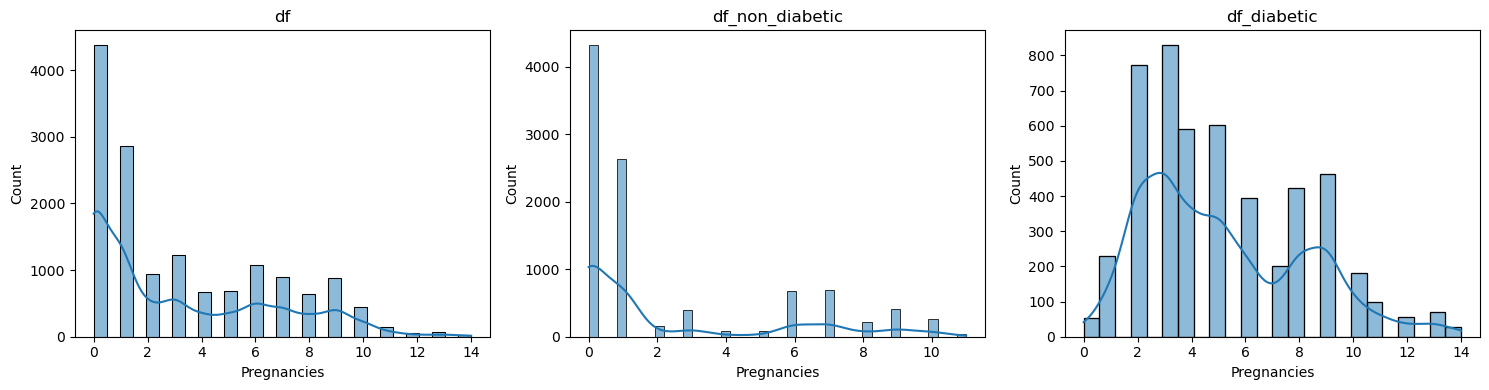

------------------------------
Comparison of data distributions for PlasmaGlucose:
------------------------------


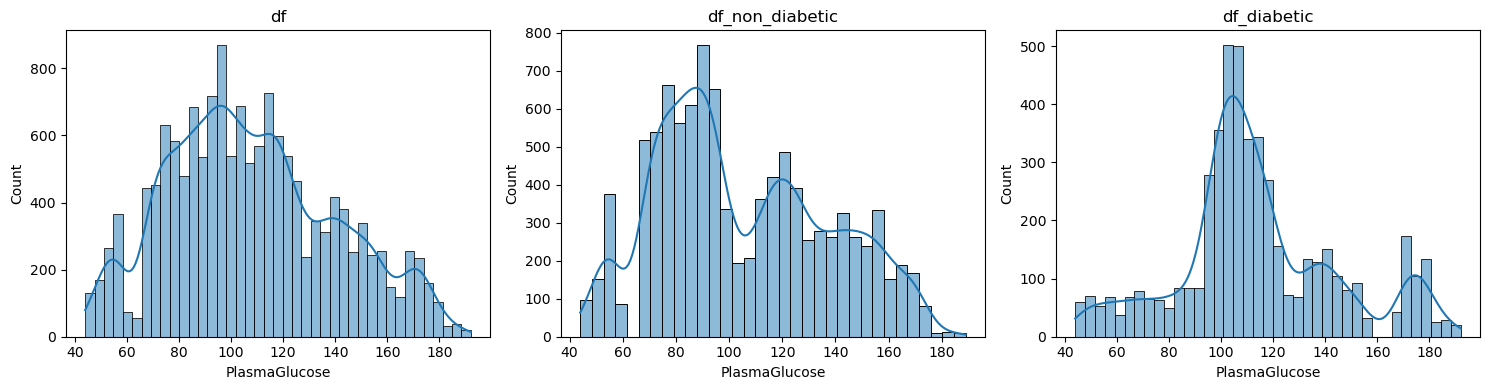

------------------------------
Comparison of data distributions for DiastolicBloodPressure:
------------------------------


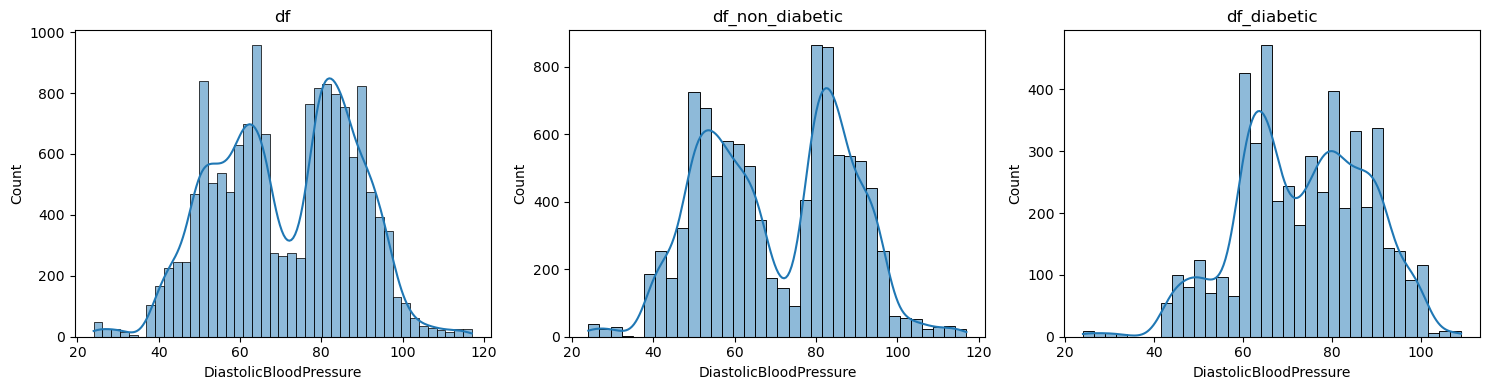

------------------------------
Comparison of data distributions for TricepsThickness:
------------------------------


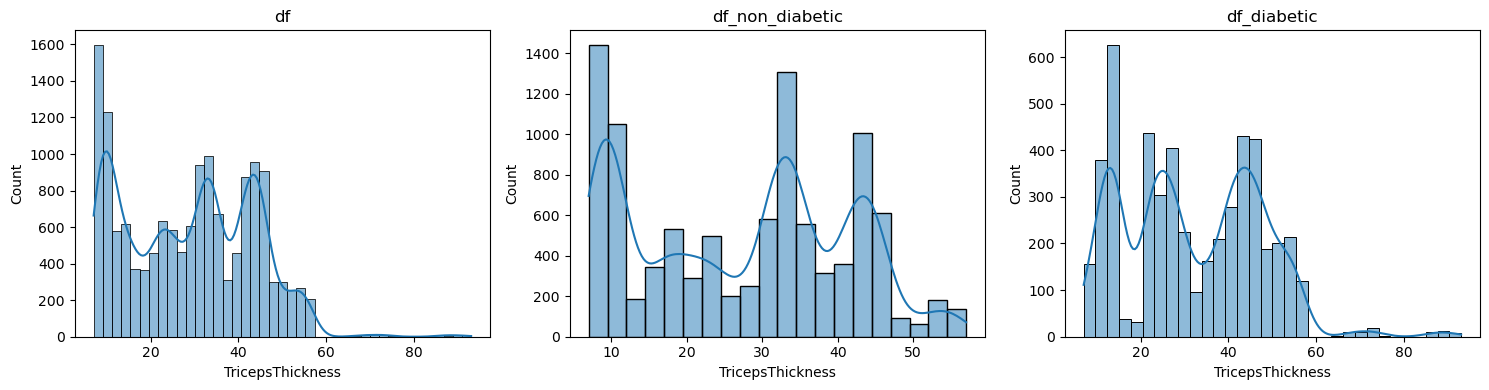

------------------------------
Comparison of data distributions for SerumInsulin:
------------------------------


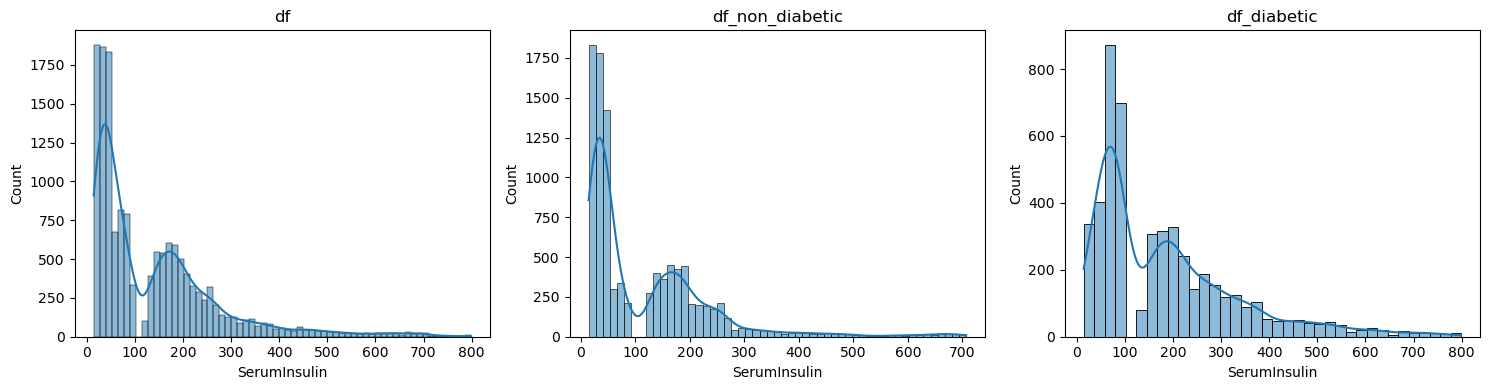

------------------------------
Comparison of data distributions for BMI:
------------------------------


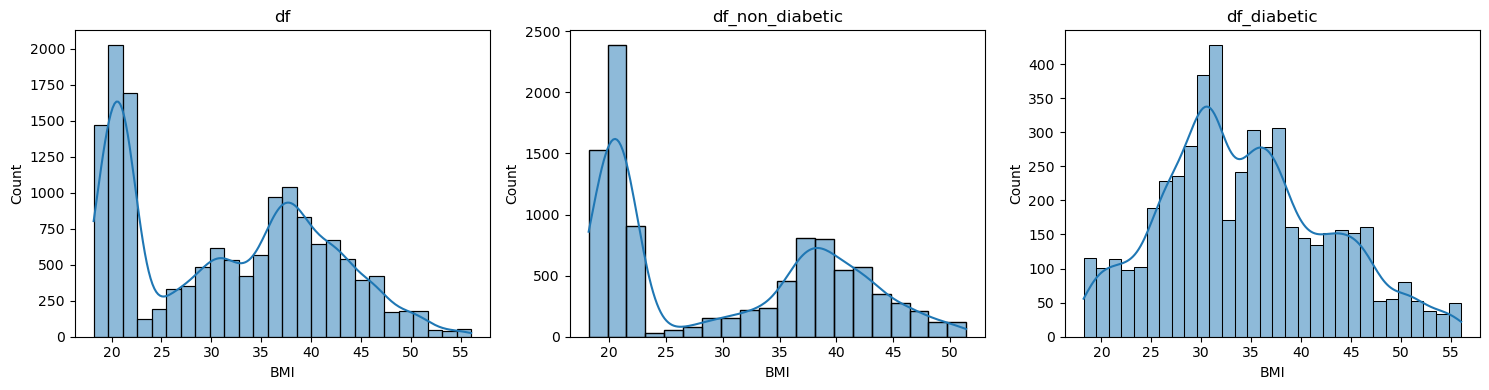

------------------------------
Comparison of data distributions for DiabetesPedigree:
------------------------------


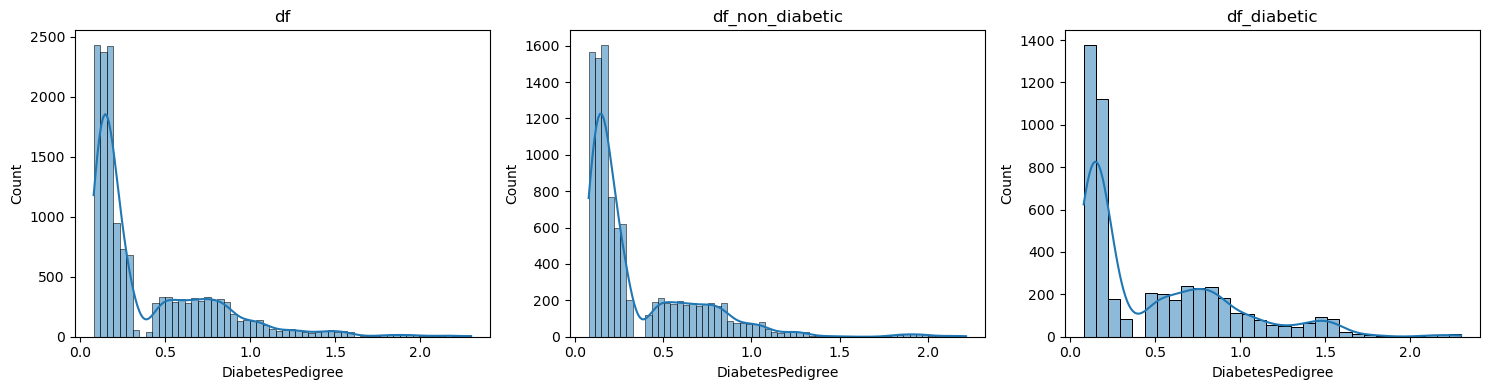

------------------------------
Comparison of data distributions for Age:
------------------------------


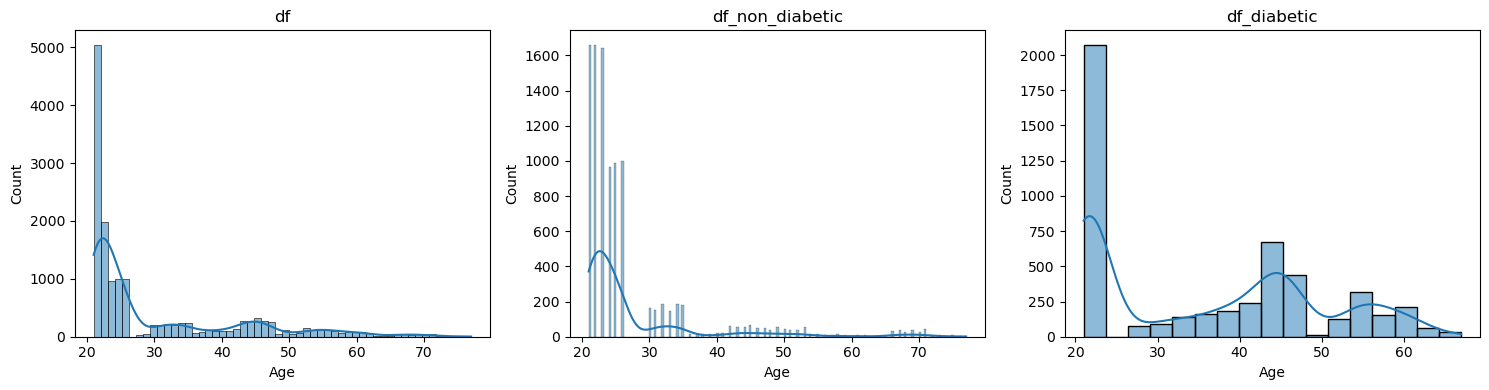

In [25]:
# All data distributions
# Reset to Matplotlib's default style
plt.style.use("default")  # Restores the default Matplotlib style

for col in diabete_df.columns:
    if col != "PatientID" and col!= "Diabetic":
        compare_histograms_per_col([diabete_df, df_non_diabetic, df_diabetic], ["df", "df_non_diabetic", "df_diabetic"], col)

global skew:  0.8235550501958153
non diabetic skew:  1.2469541170604659
diabetic skew:  0.6447623397919756


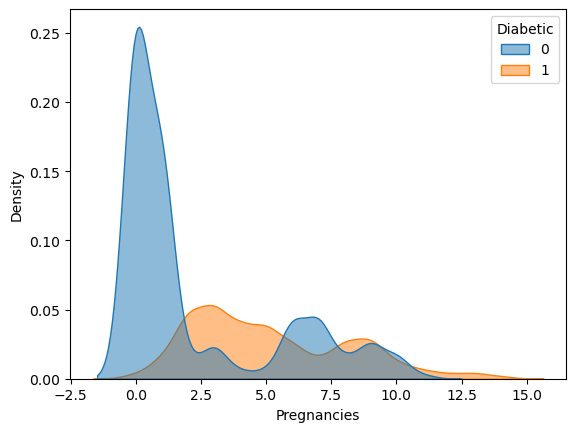

global skew:  0.3248703451313243
non diabetic skew:  0.346350135001008
diabetic skew:  0.33812814665741825


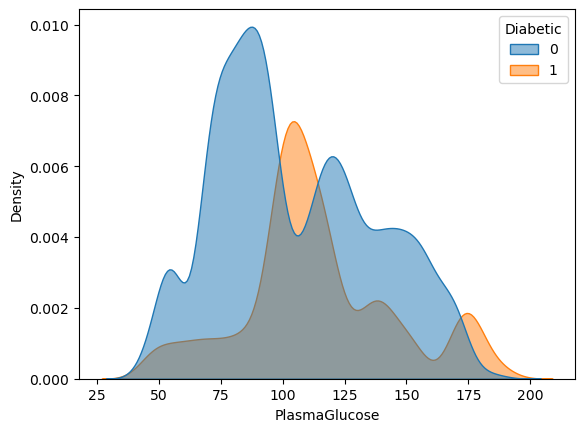

global skew:  -0.10930824868510386
non diabetic skew:  -0.024913824614621997
diabetic skew:  -0.19714588332162494


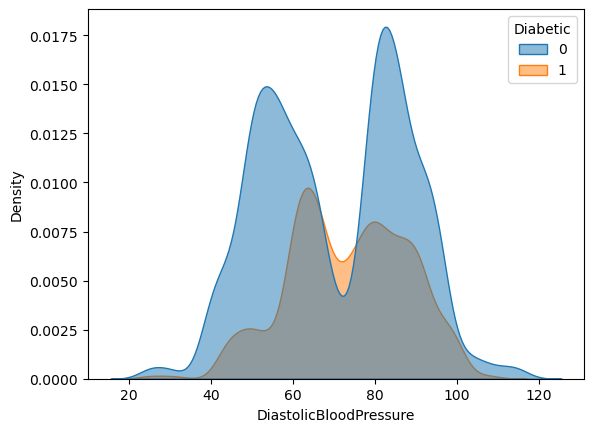

global skew:  0.1977964230003622
non diabetic skew:  0.02007033158703192
diabetic skew:  0.36744346841033476


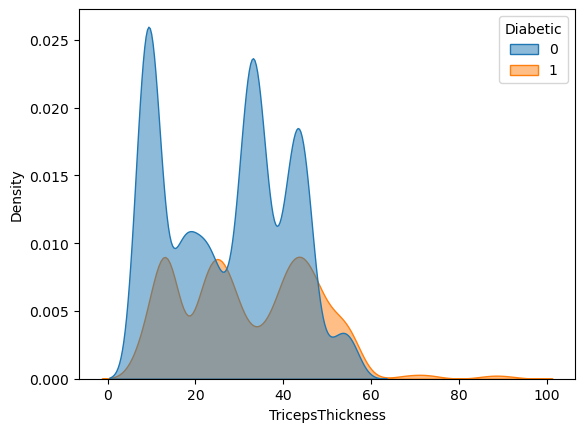

global skew:  1.767678356246713
non diabetic skew:  2.028161571195118
diabetic skew:  1.3878247488531739


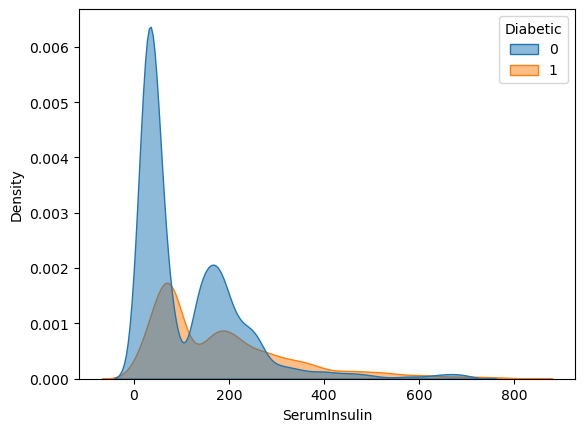

global skew:  0.19329160627090142
non diabetic skew:  0.2950865383234826
diabetic skew:  0.34270069500699496


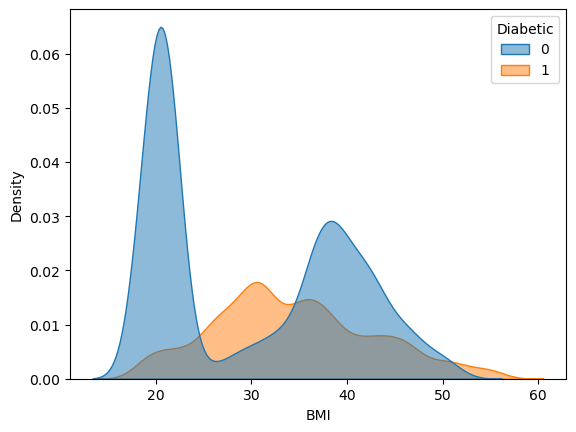

global skew:  1.6753664112057065
non diabetic skew:  1.9856271472751208
diabetic skew:  1.1773599426221475


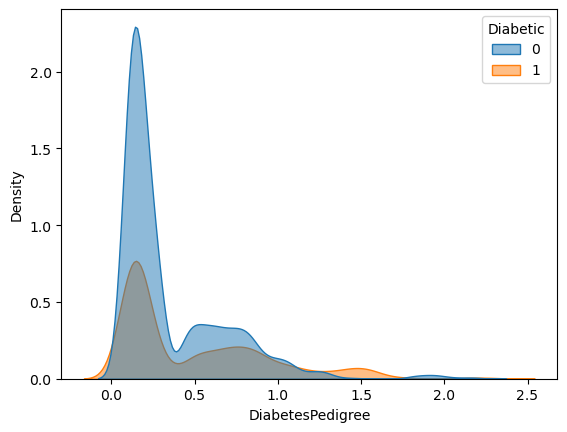

global skew:  1.4832316351256196
non diabetic skew:  2.7018067147346643
diabetic skew:  0.3132884825898529


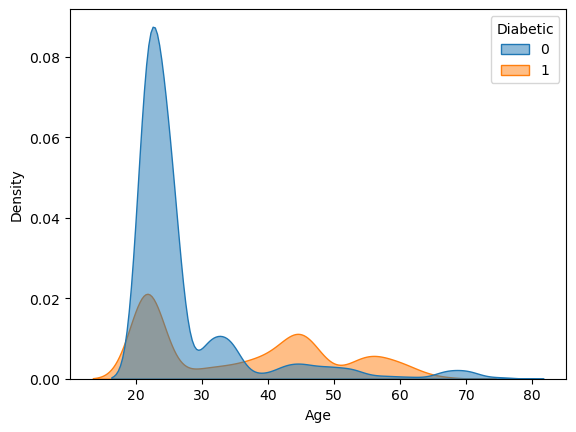

In [26]:
# Comparison of diabetic outcome vs. column
for col_name in diabete_df.columns:
    if col_name != "PatientID" and col_name!= "Diabetic":
        sns.kdeplot(data=diabete_df, x=col_name, hue="Diabetic", fill=True, alpha=0.5)
        mean_value = df_non_diabetic[col_name].mean()    # Moyenne
        median_value = df_non_diabetic[col_name].median()  # Médiane
        mode_value = df_non_diabetic[col_name].mode()[0] 


        print("global skew: ",diabete_df[col_name].skew())
        print("non diabetic skew: ",df_non_diabetic[col_name].skew())
        print("diabetic skew: ",df_diabetic[col_name].skew())
        plt.show()

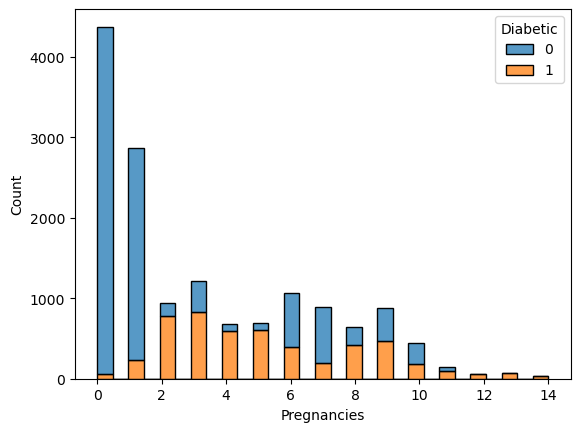

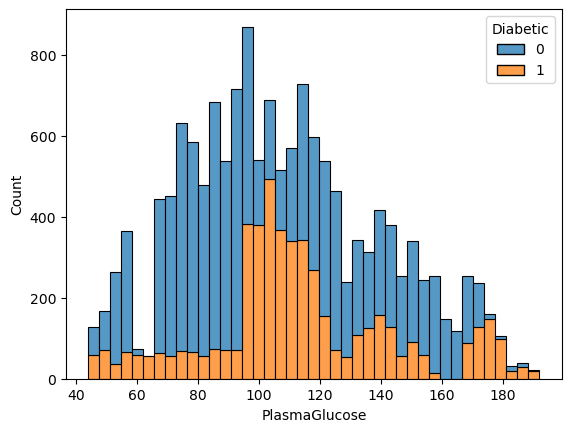

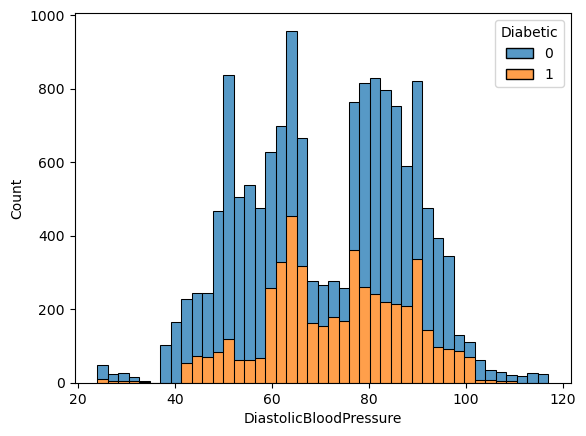

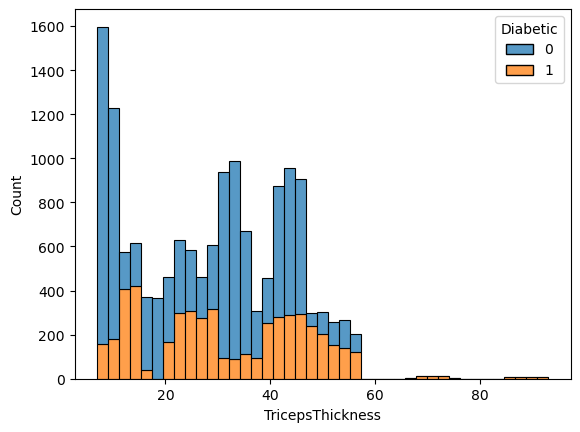

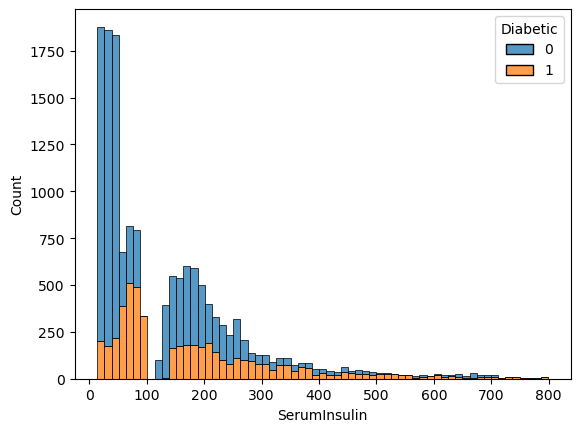

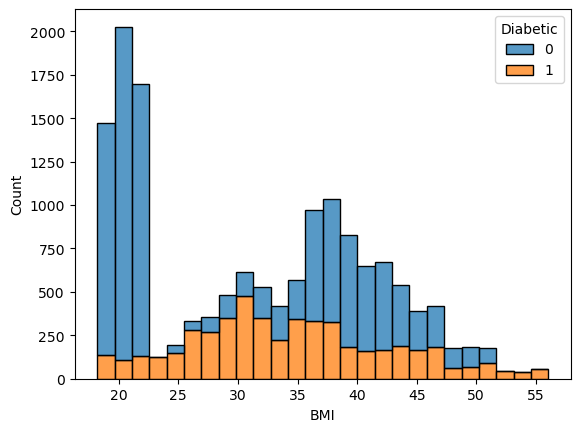

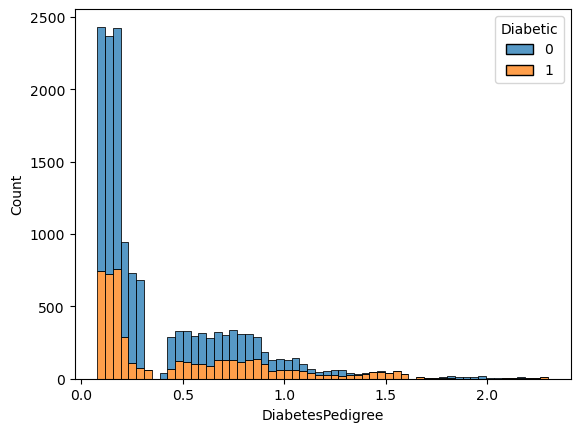

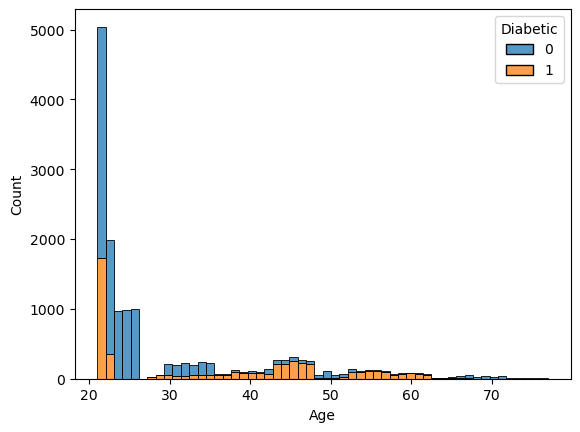

In [27]:
# Comparison of diabetic outcome vs. number of pregnancies

for col_name in diabete_df.columns:
    if col_name != "PatientID" and col_name!= "Diabetic":
        sns.histplot(data=diabete_df, x=col_name, hue="Diabetic", multiple="stack")
    plt.show()

#### **Pregnancies data observations**:

* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have had between 0 and 6 pregnancies, whereas the overall range is 0 to 14 pregnancies;
* diabetic group has a higher average pregnancy count (~5.2 vs. ~2.2 for non-diabetic);
* 50% of all diabetic patient have had ≤ 5 pregnancies (vs. 1 for  non-diabetics), and 75% has had ≤8 pregnancies (vs. 3 for non-diabetics);

#### **Pregnancies data implications**: 
* **diabetes risk increases as the number of pregnancies grows**. (Median value)


#### **Plasma Glucose data observations**:
* slightly right-skewed for the full sample and non-diabetic group, roughly symetric for the diabetic group;
* 75% of all patient have a concentration between 44 and 129mg/dL, whereas the overall range is 44 to 192mg/dL;
* diabetic group has a higher average rate (~114mg/dL vs. ~105mg/dL for non-diabetic);
* 50% of all diabetic patient have a concentration of 108mg/dL (vs. 96mg/dL for  non-diabetics), and 75% have 131mg/dL (vs. 128mg/dL for non-diabetics);

#### **Plasma Glucose data implications**: 
* **Diabetic group has a slightly higher Plasma Glucose levels** than non-diabetic group (~105mg/dL vs. ~113.7mg/dL).


#### **Diastolic Blood Pressure data observations**:
* roughly bimodal data distribution across 3 data frames; Might imply that the data came from two different processes or two population group
* 75% of all patient have a diastolic blood pressure between 24 and 85mmHg, equal to the overall range
* diabetic group has a slightly higher average diastolic blood pressure level (~73.4mmHg vs. ~70.1mmHg  for non-diabetic);
* 50% of all diabetic patient has diastolic blood pressure level ≤ 74mmHg (vs. 69mmHg for non-diabetics), and 75% of both diabetic and non-diabetic groups is ≤ 85mmHg;
* 4th quartile (max) trend is reversed, where non-diabetic patients have lower diastolic blood pressure level (109mmHg vs. 117mmHg for non_diabetics).

#### **Diastolic Blood Pressure data implications**: 
* **Higher Diastolic Blood Pressure levels might have a slight impact** on the diabetic outcome.
* A diastolic blood pressure below 30, is a vital emergency (cardiac arrest, steptic shock, dehydration, massive blood lost,.. ) Patient with this readings will die without immediate medical intervention. reading this low, indicate a data collection error. We need to study the samples with a very low diastolic blood pressure in detail in order to decide if we keep and modify them or reject them.


#### **Triceps Thickness data observations**:
* roughly trimodal data distribution across 3 data frames; Might imply that the data came from three different processes or three population group
* 75% of all patient have a Triceps Skinfold Thickness (TSF) between 7 and 41mm, whereas the overall range is 7 to 93mm;
* diabetic group has a higher average TSF (~32mm vs. ~27mm for non-diabetic);
* 50% of all diabetic patient have a TSF <=29mm (vs. 31mm for  non-diabetics) The median are almost equal, and 75% have <=44mm (vs. 39mm for non-diabetics); 
* 4th quartile (max) for non diabetic is lower than the max for diabetic. In this Data Set, all patient with a TSF > 57mm are diabetic

#### **Triceps Thickness data implications**: 
* **Higher Triceps Skinfold Thickness (TSF) levels might have a huge impact on the diabetic outcome as is describe a diabete predisposition**
in fact A high TSF indicates excess subcutaneous fat, which is often associated with insulin resistance.
TSF is a good indirect indicator of insulin sensitivity, especially when it is elevated. However, it must be interpreted in conjunction with other parameters for a more accurate assessment of the risk of type 2 diabetes.

#### **Serum Insulin data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Serum Insulin concentration between 14 and 195mu U/ml, whereas the overall range is 14 to 799mu U/ml;
* diabetic group has a higher concentration average (~184mu U/ml vs. ~115mu U/mlfor non-diabetic);
* 50% of all diabetic patient have a Serum Insulin concentration <=153mu U/ml (vs. 52mu U/ml for  non-diabetics), and 75% have <=257mu U/ml (vs. 174mu U/ml for non-diabetics); 
* 4th quartile (max) In this Data Set, all patient with a Serum Insulin concentration > 707mu U/ml are diabetic

#### **Serum Insulin data implications**: 
* **Higher Serum Insulin levels have an impact on the diabetic outcome**
serum insulin is an important indicator in the prediction of type 2 diabetes, but it is not sufficient on its own, as it can be normal or low at an advanced stage of diabetes (when the pancreas is exhausted).

#### **BMI data observations**:
* bimodal data distribution across 3 data frames; Might imply that the data came from two different processes or two population group
* 75% of all patient have a Body Mass Index (BMI) between 18Kg/m^2 and 39Kg/m^2, whereas the overall range is 18Kg/m^2 to 56Kg/m^2;
* diabetic group has a higher INDEX average (~34Kg/m^2 vs. ~30Kg/m^2 for non-diabetic);
* 50% of all diabetic patient have an INDEX <=34Kg/m^2 (vs. 28Kg/m^2 for  non-diabetics), and 75% have <=40Kg/m^2 (vs. 39Kg/m^2 for non-diabetics); 

#### **BMI data implications**: 
* **Higher BMI levels might have a huge impact on the diabetic outcome as is describe a diabete predisposition**

#### **Diabetes Pedigree data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient have a Diabetes Pedigree score between 0.08 and 0.62, whereas the overall range is 0.08 to 2.30;
* diabetic group has a higher score average (~0.49 vs. ~0.35 for non-diabetic);
* 50% of all diabetic patient have an score of <=0.22 (vs. 0.19 for  non-diabetics), and 75% have <=0.77 (vs. 0.52 for non-diabetics); 

#### **Diabetes Pedigree data implications**: 
* **Higher Diabetes Pedigree score might have a slight impact on the diabetic outcome**

#### **Age data observations**:
* right-skewed data distribution ; in all three histograms (df, df_non_diabetic, df_diabetic) the distribution extends to the right;
* 75% of all patient are between 21 and 35 years old, whereas the overall range is 21 to 77;
* diabetic group is older in average (~36 years old vs. ~27 for non-diabetic);
* 50% of all diabetic patient are <=37 (vs. 24 for  non-diabetics), and 75% have <=46 (vs. 26 for non-diabetics); 

#### **Age data implications**: 
* **In average, diabetic patient are older than non-diabetic patients. Also, the risk of diabete increases as patient get older**

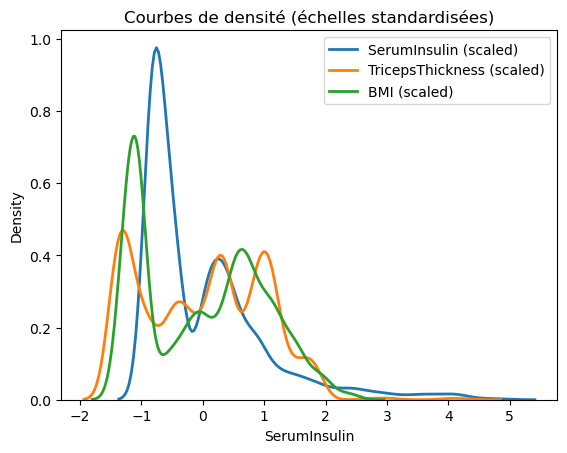

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(diabete_df[['SerumInsulin', 'TricepsThickness', 'BMI']]),
                         columns=['SerumInsulin', 'TricepsThickness', 'BMI'])

sns.kdeplot(df_scaled['SerumInsulin'], label='SerumInsulin (scaled)', linewidth=2)
sns.kdeplot(df_scaled['TricepsThickness'], label='TricepsThickness (scaled)', linewidth=2)
sns.kdeplot(df_scaled['BMI'], label='BMI (scaled)', linewidth=2)

plt.title('density standard scale')
plt.legend()
plt.show()

## **3.2 Further Bivariate analysis**

**This part is dedicated to:**
* Explore the relationships between the features other than the target;
* Understand if we can and should develop additional features.

<Axes: >

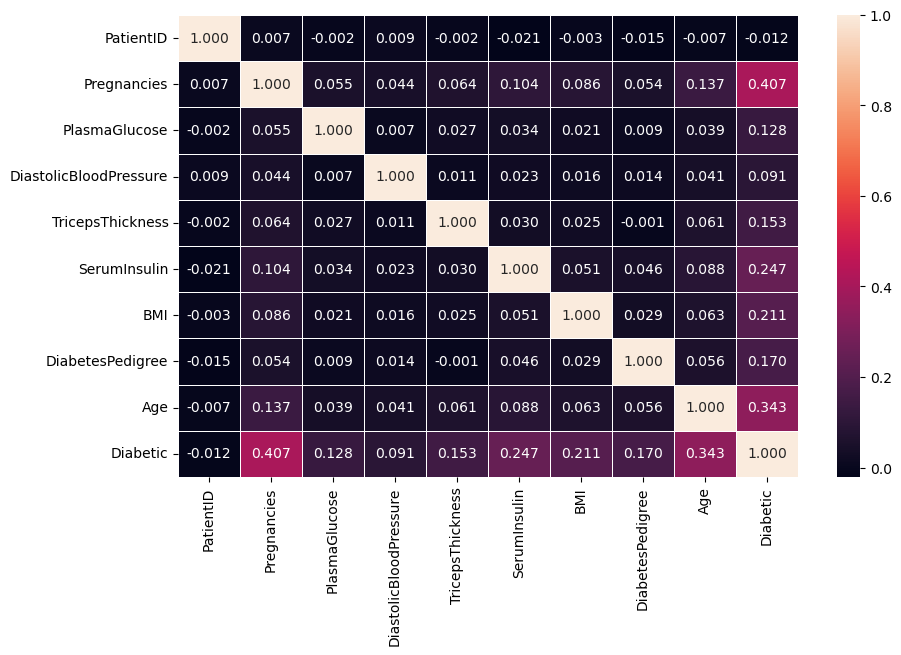

In [36]:
# Vérifier les dépendances des mesures médicales dans l'apparition du diabete  ==> Il y a un lien plus fort entre le vieillissement (Age) et l'apparition de Diabete et aussi entre le nombre de Grossesse et l'apparition du Diabete
# les mesures sont très peu correlées entre elles ==> donc on peut déduire que l'ensemble des colonne speuvent être utiles dans notre ML
# correlation entre l'age et la grossesse ==> laquelle des 2 est predominante dans l'apparition du diabete?
#Attention la correlation n'est pas la causalité

# Heatmap correlation matrix
f, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(diabete_df.corr(), annot=True, fmt=".3f", linewidths=.5, ax=ax)

The positive correlation hints to us that the above present features have a positive relationship to our target (Diabetic), meaning that as they increase, the possibility of having a diabetes increases as well.

**Strongest to weakest diabetic relationships**: 
* Pregancies (~0.41)
* Age (~0.34)
* Seruminsulin (~0.25)
* BMI (~0.21)
* DiabetesPedigree (~0.17)
* Triceps Thickness (~0.15)
* PlasmaGlucose (~0.13)
* DiastolicBloodPressure (~0.09)

**Other relationships worth taking a closer look at**:
* Age vs. Pregnancies (~0.14)
* Pregnancies vs. Serum Insulin (~0.1)
* Age vs. Serum Insulin (~0.09)
* Pregnancies vs. BMI (~0.09)

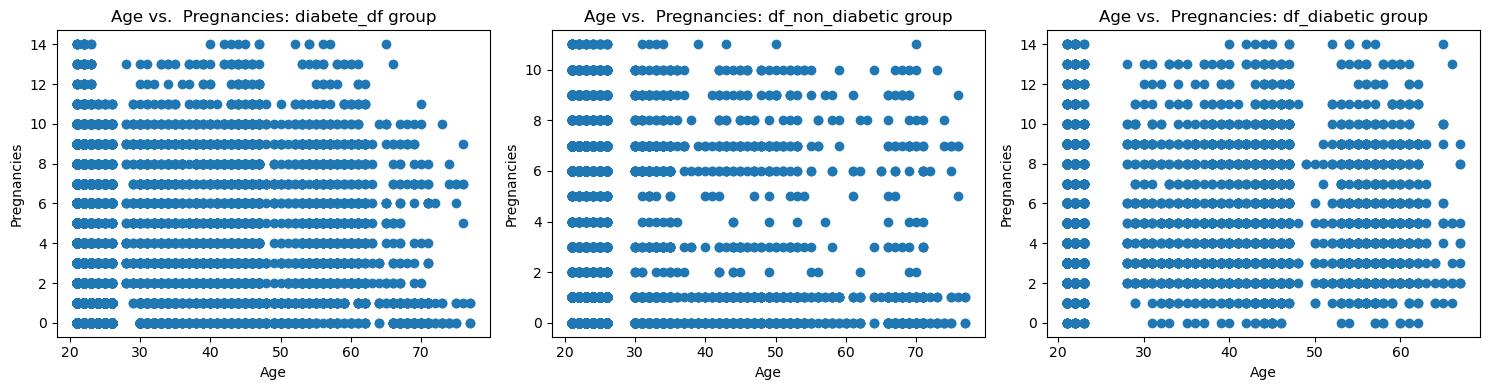

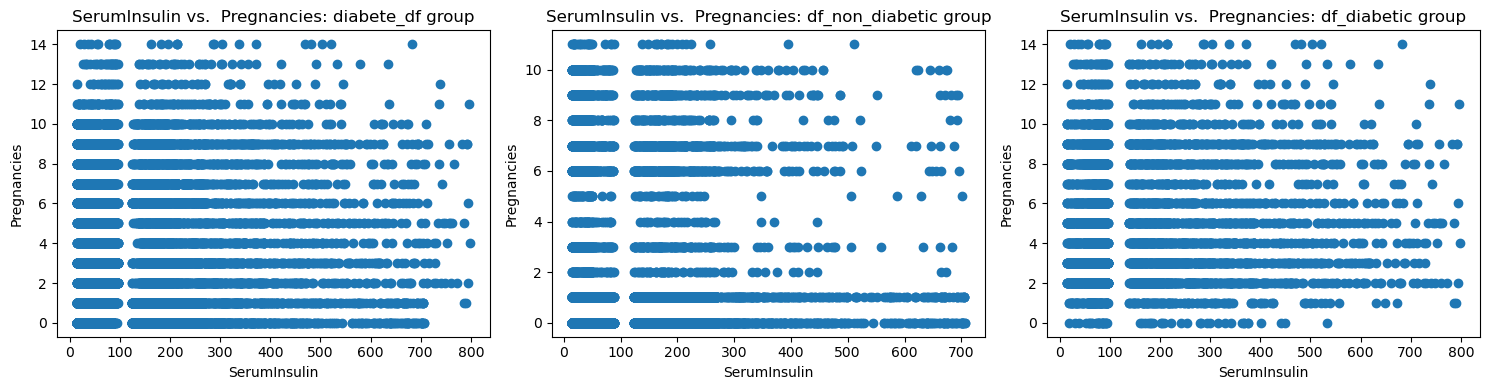

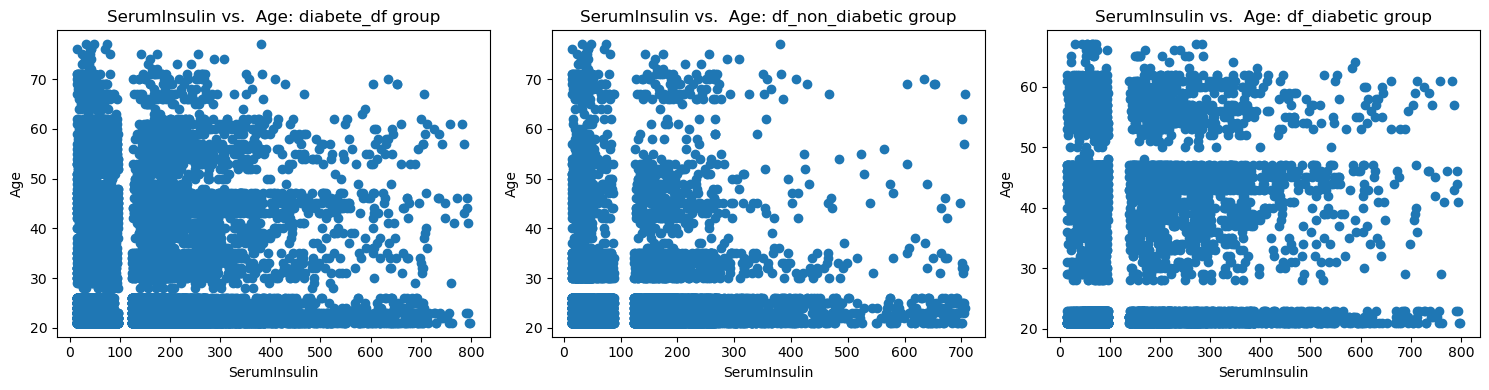

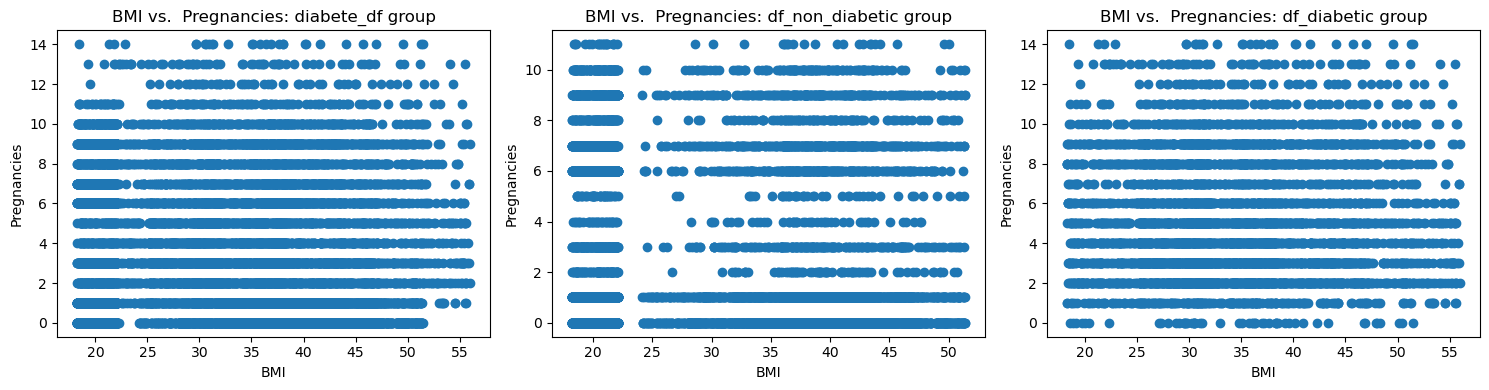

In [37]:
# Number of pregnancies vs. BMI: non-diabetic group

study_pair = [("Age","Pregnancies"),("SerumInsulin","Pregnancies"),("SerumInsulin","Age"),("BMI","Pregnancies")]
for x,y in study_pair:
    point_clouds_per_col([diabete_df,df_non_diabetic,df_diabetic],["diabete_df","df_non_diabetic","df_diabetic"],x,y)

## **3.3 Outliers detection**

**This part is dedicated to:**
* Detect the presence of potential outliers;
* Decide on how to treat the outliers present in the dataset.

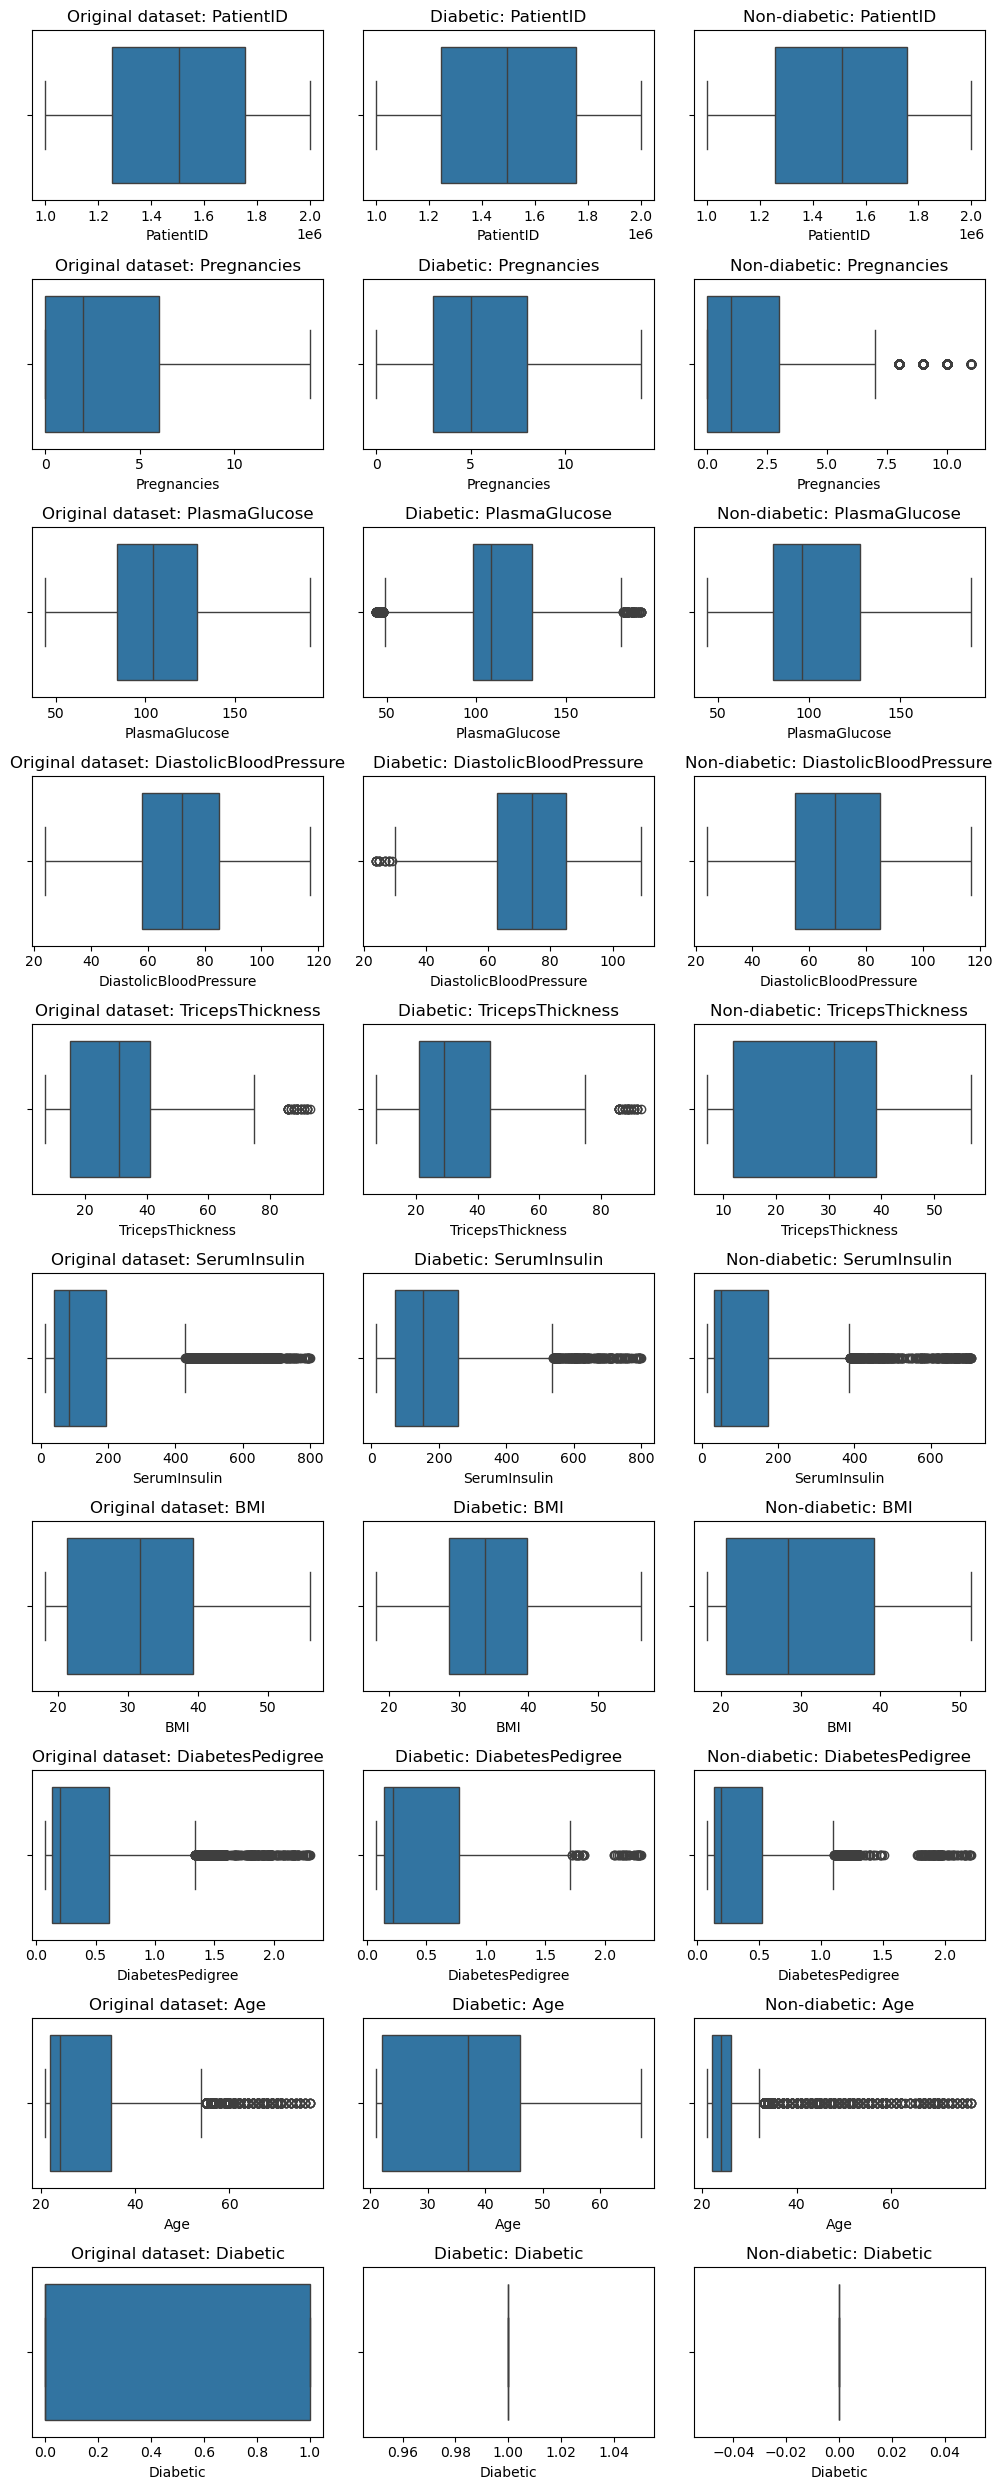

In [38]:
# Data distributions across the columns for the whole dataframe vs diabetic & non-diabetic groups
columns = diabete_df.columns
nb_rows = len(columns)

fig, axes = plt.subplots(ncols=3, nrows=nb_rows, figsize=(10, 25))

for i, col in enumerate(columns):
    
    sns.boxplot(data=diabete_df, x=col, ax=axes[i, 0])
    axes[i, 0].set_title(f"Original dataset: {col}")
    
    sns.boxplot(data=df_diabetic, x=col, ax=axes[i, 1])
    axes[i, 1].set_title(f"Diabetic: {col}")
    
    sns.boxplot(data=df_non_diabetic, x=col, ax=axes[i, 2])
    axes[i, 2].set_title(f"Non-diabetic: {col}")

plt.tight_layout()
plt.show()

In [ ]:
#outliers[outliers["Age"] == 21]   # parmis les outliers ceux qui ont 21 ans et il apparaît 1144 lignes
Nombre_de_grossesse = outliers[outliers["Age"] == 21]["Pregnancies"].unique()
print (Nombre_de_grossesse)
for i in sorted(Nombre_de_grossesse):
    outliers_21_i= outliers[outliers["Pregnancies"] == i ] #and outliers["Age"] == 21 ]  
    outliers_21_i = outliers_21_i [outliers_21_i["Age"] == 21 ]
    print ("grossesse", i, "nombre de femmes", len(outliers_21_i) )

[ 2  3  8  9  4  0 11 14  1  7 10  6  5 12 13]
grossesse 0 nombre de femmes 19
grossesse 1 nombre de femmes 18
grossesse 2 nombre de femmes 17
grossesse 3 nombre de femmes 14
grossesse 4 nombre de femmes 13
grossesse 5 nombre de femmes 9
grossesse 6 nombre de femmes 8
grossesse 7 nombre de femmes 3
grossesse 8 nombre de femmes 8
grossesse 9 nombre de femmes 20
grossesse 10 nombre de femmes 13
grossesse 11 nombre de femmes 8
grossesse 12 nombre de femmes 3
grossesse 13 nombre de femmes 2
grossesse 14 nombre de femmes 4


---
# **4. FEATURE ENGINEERING**
---

Goals : 
* Feature selection
* Data normalization
    * Repeated values - time to act now
    * Continuous values binning ?
    * class imbalances - SMOTE ?
* Outliers treatment
    * cap the outliers to min and max values, but be smart about it like titanic example - winsorization ?
* Data encoding
* False positive vs false negative? - rather positive, because of the context, but needs to be more argumented
    * Using class weights may lead to have slightly more false positives, but that's okay in this context.

In [ ]:
# we add a column to the dataset to check for possible hidden correlation between plasmaGlucose, Insulin  and Diabete.
cp = diabete_df.copy()
cp["InsulinGlucoseRatio"] = cp["SerumInsulin"] / cp["PlasmaGlucose"]
cp.corr()
# the correlation matrix doesn't show better correlation, it isn't worth keeping.


,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic,InsulinGlucoseRatio
PatientID,1.000000,0.006774,-0.001858,0.008746,-0.002406,-0.020698,-0.003156,-0.015413,-0.007096,-0.012494,-0.016915
Pregnancies,0.006774,1.000000,0.054502,0.043528,0.063605,0.104487,0.086386,0.054240,0.136972,0.407315,0.078097
PlasmaGlucose,-0.001858,0.054502,1.000000,0.007212,0.027100,0.033545,0.020653,0.009057,0.038864,0.128004,-0.257525
DiastolicBloodPressure,0.008746,0.043528,0.007212,1.000000,0.011106,0.022649,0.015873,0.014099,0.041333,0.091307,0.020544
TricepsThickness,-0.002406,0.063605,0.027100,0.011106,1.000000,0.029688,0.024745,-0.000951,0.061383,0.152505,0.010961
SerumInsulin,-0.020698,0.104487,0.033545,0.022649,0.029688,1.000000,0.051223,0.046324,0.088007,0.247375,0.902757
BMI,-0.003156,0.086386,0.020653,0.015873,0.024745,0.051223,1.000000,0.028868,0.062910,0.210508,0.037001
DiabetesPedigree,-0.015413,0.054240,0.009057,0.014099,-0.000951,0.046324,0.028868,1.000000,0.055633,0.170302,0.034437
Age,-0.007096,0.136972,0.038864,0.041333,0.061383,0.088007,0.062910,0.055633,1.000000,0.342605,0.071371
Diabetic,-0.012494,0.407315,0.128004,0.091307,0.152505,0.247375,0.210508,0.170302,0.342605,1.000000,0.180253


In [ ]:
# we select the people with a very low DiastolicBloodPressure to check their descriptive statistics. In order to decide if we keep them or reject them.
# it is very likely that there is a reading error for those samples. 
too_low_pressure = diabete_df[diabete_df["DiastolicBloodPressure"] < 30]
for column in diabete_df.columns:
    if column != "PatientID" and column!= "Diabetic":
        statistics = [diabete_df[column].describe(), too_low_pressure[column].describe()]
        stats = pd.concat(statistics,axis =1)
        print(stats)


        Pregnancies  Pregnancies
count  15000.000000    77.000000
mean       3.224533     2.662338
std        3.391020     3.541522
min        0.000000     0.000000
25%        0.000000     0.000000
50%        2.000000     1.000000
75%        6.000000     5.000000
max       14.000000    14.000000
       PlasmaGlucose  PlasmaGlucose
count   15000.000000      77.000000
mean      107.856867     105.519481
std        31.981975      31.856426
min        44.000000      53.000000
25%        84.000000      80.000000
50%       104.000000     100.000000
75%       129.000000     127.000000
max       192.000000     186.000000
       DiastolicBloodPressure  DiastolicBloodPressure
count            15000.000000               77.000000
mean                71.220667               25.987013
std                 16.758716                1.650307
min                 24.000000               24.000000
25%                 58.000000               25.000000
50%                 72.000000               26.000000
7

In [ ]:
#data normalization, to obtain a range between 0 and 1
engineered_df = diabete_df.copy()

for column in engineered_df.columns:
    engineered_df[columns] = (engineered_df[columns] - engineered_df[columns].min()) / (engineered_df[columns].max() - engineered_df[columns].min())
engineered_df.describe()



,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,0.502905,0.230324,0.431465,0.507749,0.253651,0.157773,0.351776,0.144330,0.163174,0.333333
std,0.289265,0.242216,0.216094,0.180201,0.169253,0.169514,0.257942,0.169973,0.215888,0.471420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.252839,0.000000,0.270270,0.365591,0.093023,0.031847,0.080863,0.026849,0.017857,0.000000
50%,0.505490,0.142857,0.405405,0.516129,0.279070,0.087898,0.358603,0.054981,0.053571,0.000000
75%,0.755198,0.428571,0.574324,0.655914,0.395349,0.230573,0.556619,0.242064,0.250000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#one hot encoding of the diabetic column = two column as results.
df_encoded = pd.get_dummies(engineered_df, columns=['Diabetic'])
df_encoded

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic_0.0,Diabetic_1.0
0,0.354755,0.000000,0.858108,0.602151,0.313953,0.011465,0.668952,0.510511,0.000000,True,False
1,0.147406,0.571429,0.324324,0.741935,0.465116,0.028025,0.080352,0.036123,0.035714,True,False
2,0.640019,0.500000,0.479730,0.247312,0.523256,0.026752,0.616137,0.000438,0.035714,True,False
3,0.883348,0.642857,0.398649,0.580645,0.209302,0.369427,0.300831,0.541848,0.392857,False,True
4,0.424098,0.071429,0.277027,0.376344,0.232558,0.026752,0.645027,0.212047,0.017857,True,False
...,...,...,...,...,...,...,...,...,...,...,...
14995,0.490282,0.714286,0.141892,0.387097,0.453488,0.207643,0.404713,0.031608,0.357143,False,True
14996,0.744403,0.142857,0.195946,0.451613,0.232558,0.196178,0.315380,0.352683,0.303571,False,True
14997,0.742734,0.000000,0.331081,0.698925,0.418605,0.054777,0.012956,0.156959,0.053571,True,False
14998,0.099319,0.000000,0.594595,0.795699,0.127907,0.187261,0.042056,0.100836,0.035714,True,False


---
# **5. MODELS TRAINING**
---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

X = df_encoded[['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'TricepsThickness', 
        'SerumInsulin', 'BMI', 'DiabetesPedigree', 'Age']]
y = df_encoded['Diabetic_1.0']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#train a random forest
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)


Accuracy: 0.9456666666666667


In [ ]:
from sklearn.svm import SVC

# train a support vector machine
svc_model = SVC()
svc_model.fit(X_train, y_train)

Accuracy: 0.8916666666666667


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# Train the model
devision_tree = DecisionTreeClassifier()
devision_tree.fit(X_train, y_train)




Accuracy: 0.8976666666666666


---
# **6. MODELS EVALUATION**
---

In [ ]:
from sklearn.metrics import confusion_matrix

# Make predictions
y_pred = random_forest.predict(X_test)

# Evaluate accuracy on test data
print("Accuracy with random_forest:", accuracy_score(y_test, y_pred))
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

FP = cm[0][1]  # False positives
FN = cm[1][0]  # False negatives

print(f"False Positive: {FP}")
print(f"False Negative: {FN}")

Accuracy with random_forest: 0.9456666666666667
          Predicted 0  Predicted 1
Actual 0         1967           68
Actual 1           95          870
False Positive: 68
False Negative: 95


In [ ]:
y_pred = svc_model.predict(X_test)

# Evaluate accuracy on test data
print("Accuracy with svc:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

FP = cm[0][1]  # False positives
FN = cm[1][0]  # False negatives

print(f"False Positive: {FP}")
print(f"False Negative: {FN}")

Accuracy with svc: 0.8916666666666667
          Predicted 0  Predicted 1
Actual 0         1905          130
Actual 1          195          770
False Positive: 130
False Negative: 195


In [ ]:
# Make predictions
y_pred = devision_tree.predict(X_test)
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Convert confusion matrix to a DataFrame for better readability
cm_df = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])
print(cm_df)

FP = cm[0][1]  # False positives
FN = cm[1][0]  # False negatives

print(f"False Positive: {FP}")
print(f"False Negative: {FN}")

Accuracy: 0.8976666666666666
          Predicted 0  Predicted 1
Actual 0         1878          157
Actual 1          150          815
False Positive: 157
False Negative: 150


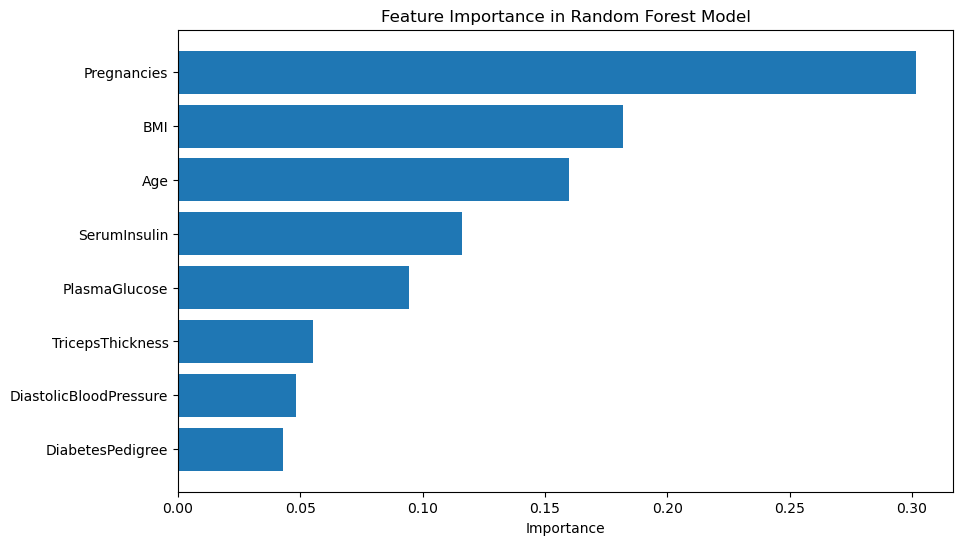

In [ ]:

# Get feature importance scores
importance = random_forest.feature_importances_

# Sort the feature importance in descending order
indices = np.argsort(importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.title("Feature Importance in Random Forest Model")
plt.barh(range(X.shape[1]), importance[indices], align="center")
plt.yticks(range(X.shape[1]), np.array(X.columns)[indices])
plt.xlabel("Importance")
plt.show()